In [8]:
import pandas as pd
# https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data
data = pd.read_csv('Store_sales_train.csv')
data

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [18]:
# modelling poultry sales
#df = data[(data['store_nbr'] == 2) & (data['family'] == 'BEVERAGES') & (data['sales'] > 0) ] 
df = data[(data['store_nbr'] == 2) & (data['family'] == 'POULTRY') & (data['sales'] > 0) ] 
df = df.set_index('date')
train_data = df['sales']
train_data2 = train_data[:-100]
type(train_data.index)
print(len(train_data))

1679


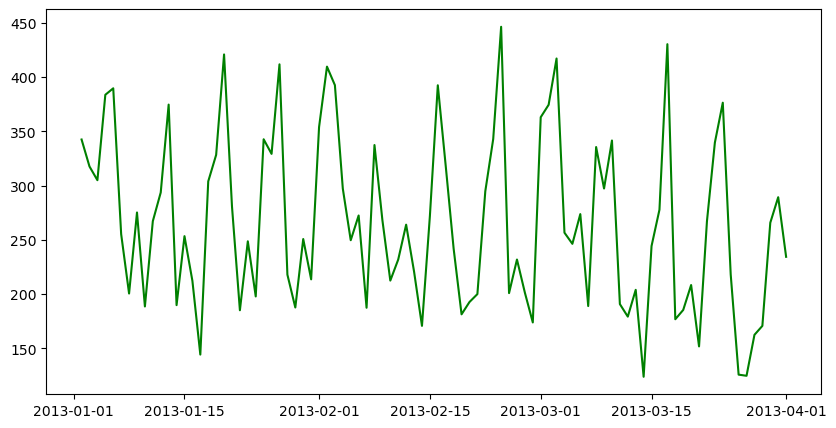

In [10]:
#checking seasonality in the data using plots
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10,5))
data_to_plot = train_data2
data_to_plot.index = pd.DatetimeIndex(data_to_plot.index).to_period('d')
data2 = data_to_plot.to_timestamp(freq='d')

plt.plot(data2[:90], label = 'actual data', color="green" )

In [21]:
# !pip install tbats
#!pip install sktime
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon


y_train, y_test = temporal_train_test_split(data2, test_size = 0.1)# 10% of the data for testing 
y_train.index= pd.DatetimeIndex(y_train.index).to_period('d')
y_test.index= pd.DatetimeIndex(y_test.index).to_period('d')
fh = ForecastingHorizon(y_test.index, is_relative=False)

#box-cox transformation:a statistical technique that transforms your target variable
#so that your data closely resembles a normal distribution. This help making the residuals of the model as normal as possible
# and thus leads to better forecasting performance
# n_jobs: How many jobs to run in parallel when fitting TBATS model.
# monthly and weekly seasonalities
forecastor = TBATS(sp=[ 7, 30], use_box_cox=True, n_jobs=5)# with box_cox transformation 
forecastor2 = TBATS(sp=[ 7, 30], use_box_cox=False, n_jobs=5)# box_cox transformation is disabled
fitted_model = forecastor.fit(y_train)
fitted_model2 = forecastor2.fit(y_train)
print(forecastor, forecastor2)

TBATS(n_jobs=5, sp=[7, 30], use_box_cox=True) TBATS(n_jobs=5, sp=[7, 30], use_box_cox=False)


In [22]:
# forecasting using the first and second models: with and without Cox_Box transformation
y_pred = forecastor.predict(fh)
y_pred2 = forecastor2.predict(fh)

y_pred[:31]

date
2016-11-29    435.293771
2016-11-30    469.053531
2016-12-01    358.737733
2016-12-02    680.352288
2016-12-03    567.444920
2016-12-04    682.392107
2016-12-05    466.123289
2016-12-06    417.723508
2016-12-07    447.631427
2016-12-08    340.625047
2016-12-09    656.131724
2016-12-10    552.965209
2016-12-11    677.404144
2016-12-12    472.873147
2016-12-13    434.279893
2016-12-14    474.687027
2016-12-15    369.224240
2016-12-16    704.953463
2016-12-17    595.895730
2016-12-18    720.441934
2016-12-19    498.540929
2016-12-20    448.743349
2016-12-21    479.056565
2016-12-22    364.409213
2016-12-23    687.148571
2016-12-24    574.165854
2016-12-26    478.701776
2016-12-27    433.658950
2016-12-28    468.119896
2016-12-29    359.386117
2016-12-30    684.294173
Freq: D, Name: sales, dtype: float64

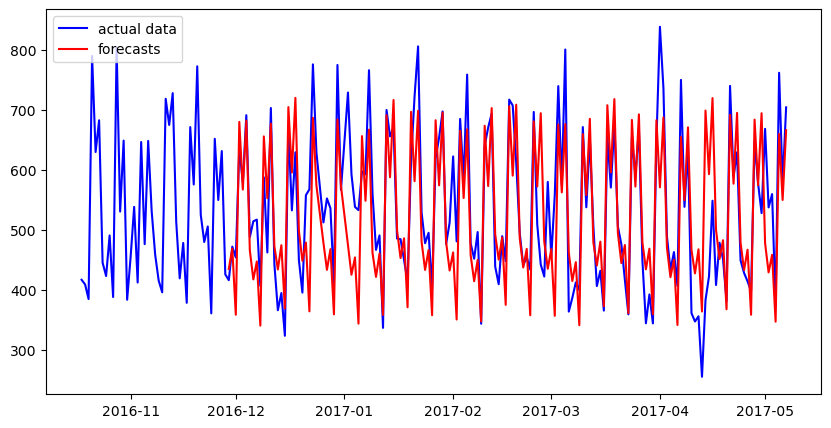

In [23]:
# plotting true against forecasts using the first model.
df_forecast=pd.DataFrame(data= y_pred, index=y_test.index)

df_forecast = df_forecast.to_timestamp(freq='d')
fig, ax = plt.subplots(figsize = (10,5))
train_data2.index = pd.DatetimeIndex(train_data2.index).to_period('d')
train = train_data2.to_timestamp(freq='d')
plt.plot(train[-200:], label = 'actual data', color="blue" )
plt.plot(df_forecast, label= 'forecasts', color = 'red')
plt.legend(loc="upper left")
plt.show()

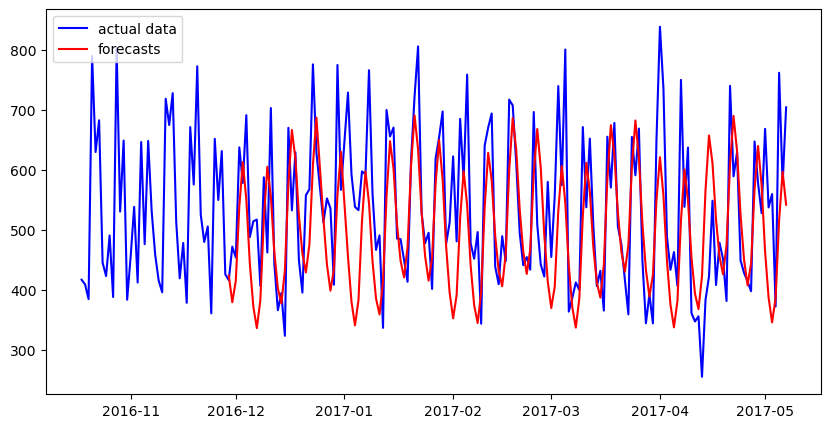

In [24]:
# plotting true against forecasts using the second model.
df_forecast2=pd.DataFrame(data= y_pred2, index=y_test.index)

df_forecast2 = df_forecast2.to_timestamp(freq='d')
fig, ax = plt.subplots(figsize = (10,5))

plt.plot(train[-200:], label = 'actual data', color="blue" )
plt.plot(df_forecast2, label= 'forecasts', color = 'red')
plt.legend(loc="upper left")
plt.show()

In [25]:
# TBATS forecasting model evaluation: comparison
from sklearn.metrics import mean_absolute_percentage_error
print('mean absolute percentage error on test data using box-cox transformer is:', mean_absolute_percentage_error(y_pred, y_test))
print('mean absolute percentage error on test data without using box-cox transformer is:', mean_absolute_percentage_error(y_pred2, y_test))

mean absolute percentage error on test data using box-cox transformer is: 0.12534766373642992
mean absolute percentage error on test data without using box-cox transformer is: 0.18088828584131061
